In [1]:
from skimage import metrics
from skimage.filters import threshold_otsu
from skimage.feature import blob_log, blob_dog
import torch
import numpy as np
import os
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from src.dataloader import DendritePFMDataset
from scipy import ndimage as ndi
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

plt.rcParams["image.cmap"] = "coolwarm"

def fractal_dimension_boxcount(img, threshold=None, n_scales=8, min_box_size=2):
    if img.ndim == 3:
        img = img.mean(axis=-1)
    img = img.astype(float)
    if threshold is None:
        threshold = threshold_otsu(img)
    Z = img > threshold
    p = min(Z.shape)
    max_box_size = max(min_box_size + 1, p // 2)
    sizes = np.logspace(np.log10(min_box_size), np.log10(max_box_size),
                        num=n_scales, dtype=int)
    sizes = np.unique(sizes)
    counts = []
    for size in sizes:
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], size), axis=0),
            np.arange(0, Z.shape[1], size), axis=1)
        counts.append(np.count_nonzero(S))
    counts = np.array(counts)
    valid = counts > 0
    sizes = sizes[valid]
    counts = counts[valid]
    if len(sizes) < 2:
        return np.nan, sizes, counts
    log_inv_eps = np.log(1.0 / sizes.astype(float))
    log_N = np.log(counts.astype(float))
    coeffs = np.polyfit(log_inv_eps, log_N, 1)
    return coeffs[0], sizes, counts

def shape_index(img):
    gy, gx = np.gradient(img)
    gyy, gyx = np.gradient(gy)
    gxy, gxx = np.gradient(gx)
    H = (gxx + gyy) / 2.0
    K = gxx * gyy - gxy * gyx
    eta = np.arctan2(H, np.sqrt(np.abs(H**2 - K))) / np.pi + 0.5
    return eta

def annotate_box(ax, text, loc=(0.01, 0.99), fontsize=10):
    ax.text(loc[0], loc[1], text,
            transform=ax.transAxes,
            fontsize=fontsize,
            va="top", ha="left",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7))

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_dataset = DendritePFMDataset(
    (3, 64, 64),
    os.path.join("data", "dataset_split.json"),
    split="test"
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=True
)

vae = torch.load(os.path.join(
    r"/home/xtanghao/THPycharm/dendrites_pfm_vae/tmp/old_results_/V4_latent_size8_noise0.8_kl0.01_grad0.1_20251127_222001/ckpt/CVAE.ckpt",
    # "ckpt", "best.pt"
), weights_only=False).to(device)
vae.eval()

VAE(
  (encoder): ResEncoder(
    (layers): Sequential(
      (0): MultiKernelResBlock(
        (conv3): Conv2d(3, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (conv5): Conv2d(3, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
        (conv7): Conv2d(3, 512, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (shortcut): Sequential(
          (0): Conv2d(3, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): MultiKernelResBlock(
        (conv3): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (conv5): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
        (conv7): Conv2d(512, 1024, kernel_size

In [3]:
num_vis = 5
# np.random.seed(0)
indices_vis = np.random.choice(len(test_dataset), size=num_vis, replace=False)
print("Randomly selected indices for visualization:", indices_vis)

Randomly selected indices for visualization: [114 162 172 200 376]


tensor([0.0344, 0.6516, 0.5639, 0.8324, 0.8597, 0.9791, 0.7665, 0.8499, 0.6608,
        0.1876, 0.9935, 0.9816, 0.4024, 0.0900, 0.7386])


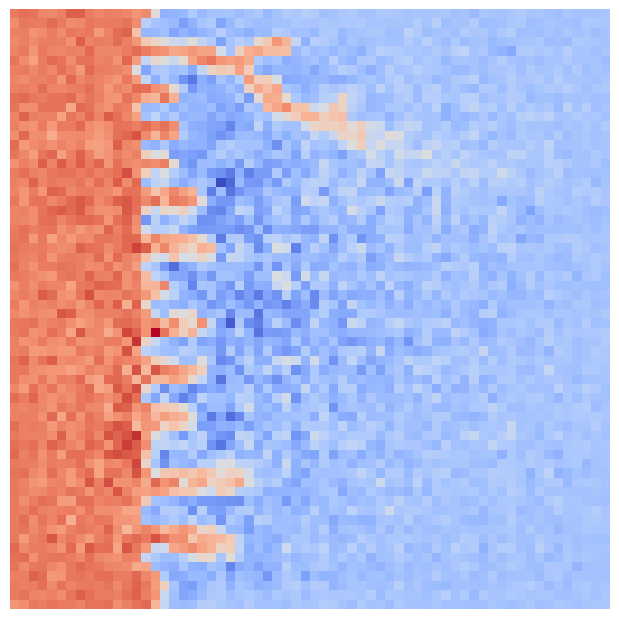

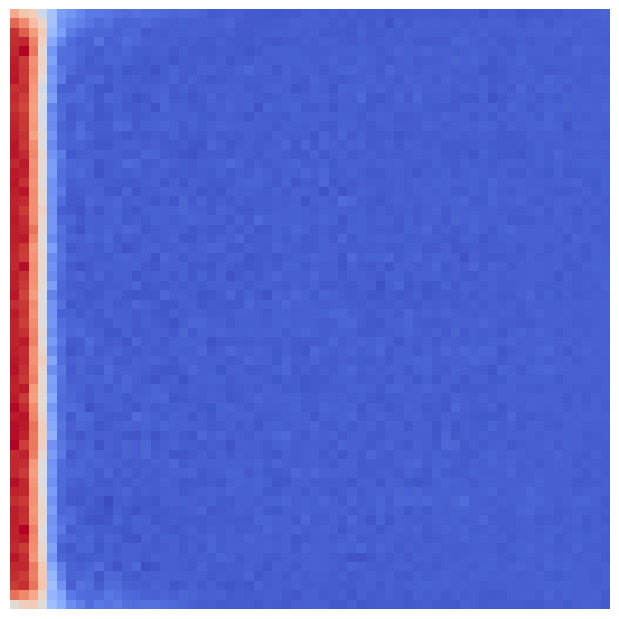

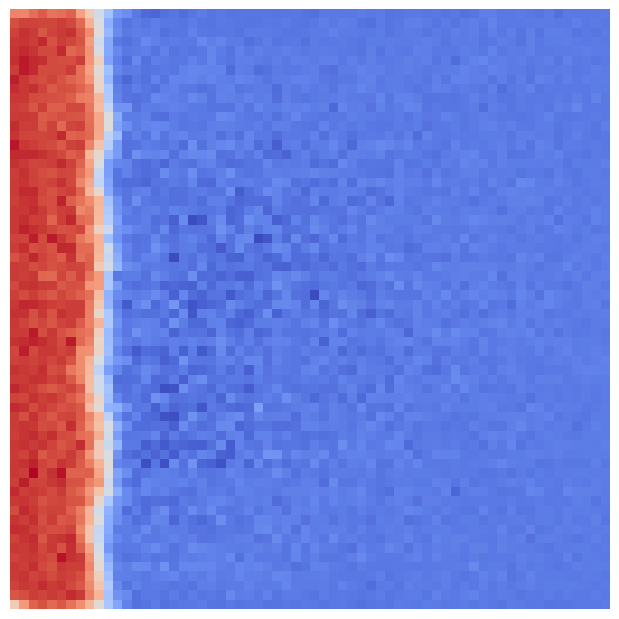

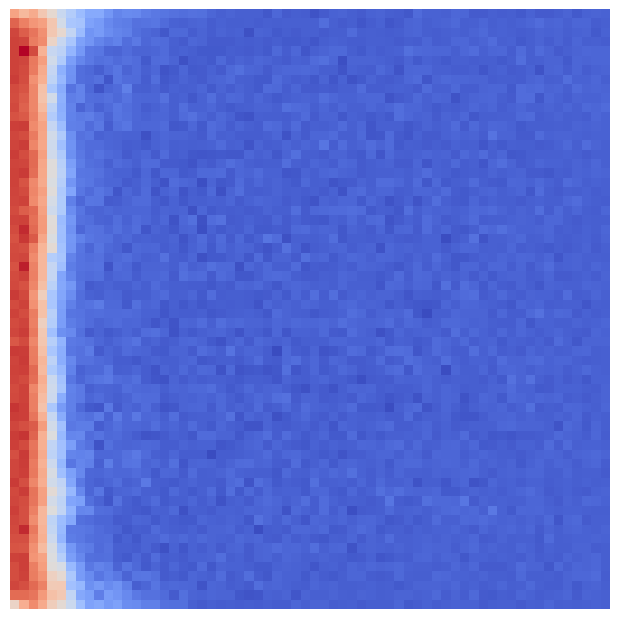

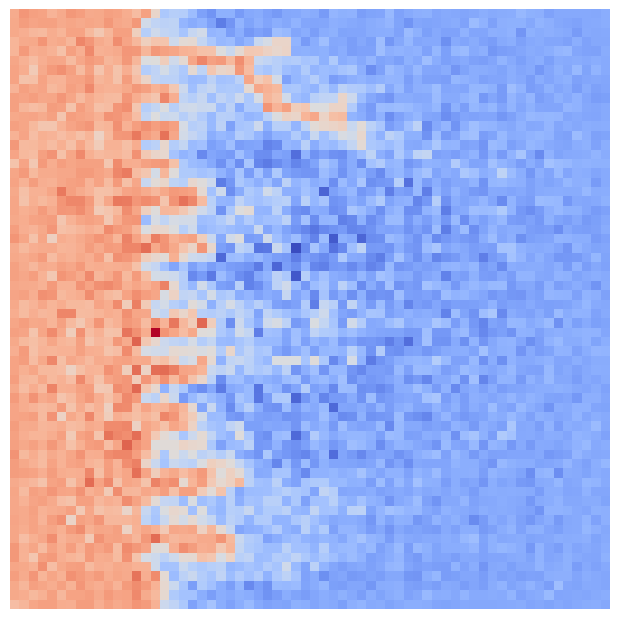

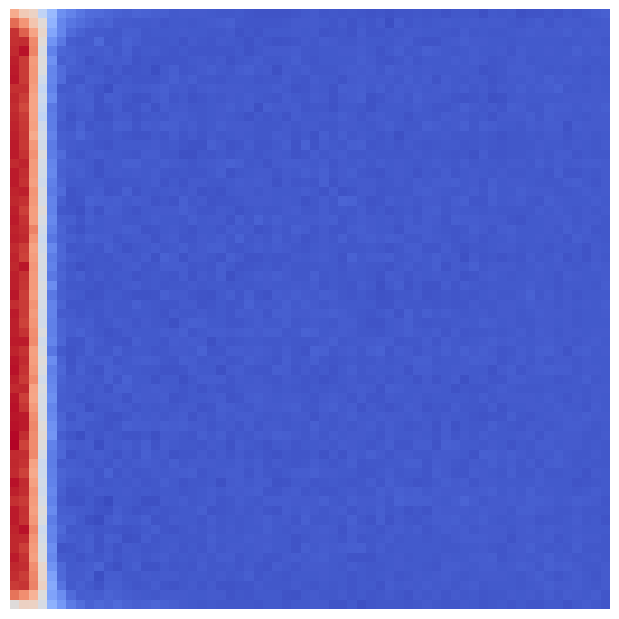

In [4]:
from src.tools import show_image_no_frame

a = indices_vis[0]
b = indices_vis[1]
x_a, y_a, did_a, xo_a = test_dataset[a]
x_b, y_b, did_b, xo_b = test_dataset[b]

print(y_a)
with torch.no_grad():
    
    x_a = x_a.unsqueeze(0).to(device)
    y_a = y_a.unsqueeze(0).to(device)
    x_b = x_b.unsqueeze(0).to(device)
    y_b = y_b.unsqueeze(0).to(device)
    
    recon_x_aa = vae(x_a, y_a)[0]
    recon_x_bb = vae(x_b, y_b)[0]
    recon_x_na = vae.inference(y_a)
    recon_x_nb = vae.inference(y_b)
    recon_x_ab = vae(x_a, y_b)[0]
    recon_x_ba = vae(x_b, y_a)[0]

    recon_x_aa = recon_x_aa[0, 0].detach().cpu().numpy()
    recon_x_bb = recon_x_bb[0, 0].detach().cpu().numpy()
    recon_x_na = recon_x_na[0, 0].detach().cpu().numpy()
    recon_x_nb = recon_x_nb[0, 0].detach().cpu().numpy()
    recon_x_ab = recon_x_ab[0, 0].detach().cpu().numpy()
    recon_x_ba = recon_x_ba[0, 0].detach().cpu().numpy()

    show_image_no_frame(recon_x_aa)
    show_image_no_frame(recon_x_bb)
    show_image_no_frame(recon_x_na)
    show_image_no_frame(recon_x_nb)
    show_image_no_frame(recon_x_ab)
    show_image_no_frame(recon_x_ba)